In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

## Load data

In [2]:
samples = pd.read_csv("dataset_mood_smartphone.csv", 
                      sep=',', 
                      index_col=0, 
                      parse_dates=["time"],
                      dtype={"id": "category", "variable": "category"})
samples = samples.rename(columns={"time": "datetime"})
samples

,id,datetime,variable,value
1,AS14.01,2014-02-26 13:00:00.000,mood,6.000
2,AS14.01,2014-02-26 15:00:00.000,mood,6.000
3,AS14.01,2014-02-26 18:00:00.000,mood,6.000
4,AS14.01,2014-02-26 21:00:00.000,mood,7.000
5,AS14.01,2014-02-27 09:00:00.000,mood,6.000
...,...,...,...,...
2770399,AS14.30,2014-04-11 07:51:16.948,appCat.weather,8.032
2772465,AS14.30,2014-04-19 11:00:32.747,appCat.weather,3.008
2774026,AS14.30,2014-04-26 10:19:07.434,appCat.weather,7.026
2774133,AS14.30,2014-04-27 00:44:48.450,appCat.weather,23.033


## Remove duplicates

In [4]:
dupes = samples.duplicated(subset=['datetime', 'variable', 'id'], keep='last')
samples_deduped = samples[dupes == False]

## Remove negative values for appCat.* variables

In [5]:
samples_cleaned = samples_deduped[(~(samples_deduped['variable'].str.startswith('app'))) |
                                   ((samples_deduped['variable'].str.startswith('app')) & 
                                   (samples_deduped['value'] > 0))]
samples_cleaned

,id,datetime,variable,value
1,AS14.01,2014-02-26 13:00:00.000,mood,6.000
2,AS14.01,2014-02-26 15:00:00.000,mood,6.000
3,AS14.01,2014-02-26 18:00:00.000,mood,6.000
4,AS14.01,2014-02-26 21:00:00.000,mood,7.000
5,AS14.01,2014-02-27 09:00:00.000,mood,6.000
...,...,...,...,...
2770399,AS14.30,2014-04-11 07:51:16.948,appCat.weather,8.032
2772465,AS14.30,2014-04-19 11:00:32.747,appCat.weather,3.008
2774026,AS14.30,2014-04-26 10:19:07.434,appCat.weather,7.026
2774133,AS14.30,2014-04-27 00:44:48.450,appCat.weather,23.033


## Remove outliers

In [6]:
## Todo

## Pivot the data to a time indexed data frame 
https://pandas.pydata.org/docs/user_guide/reshaping.html

In [7]:
vdata = samples_cleaned.pivot(index="datetime", columns=["id", "variable"], values="value")
vdata

id,AS14.01,AS14.02,AS14.03,AS14.05,AS14.06,AS14.07,AS14.08,AS14.09,AS14.12,AS14.13,...,AS14.06,AS14.09,AS14.12,AS14.16,AS14.25,AS14.26,AS14.27,AS14.28,AS14.30,AS14.32
variable,mood,mood,mood,mood,mood,mood,mood,mood,mood,mood,...,appCat.weather,appCat.weather,appCat.weather,appCat.weather,appCat.weather,appCat.weather,appCat.weather,appCat.weather,appCat.weather,appCat.weather
datetime,,,,,,,,,,,,,,,,,,,,,
2014-02-17 07:00:52.197,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-02-17 07:12:13.631,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-02-17 07:49:19.635,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-02-17 08:57:16.313,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-02-17 08:58:58.471,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-06-08 11:03:34.453,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-06-08 11:04:20.233,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [102]:
ids = list(samples["id"].unique())
d = {}
for id in ids:
    d[(id, "mood")] = vdata.loc[:, (id , 'mood')].resample('D').mean()
    d[(id, "valence")] = vdata.loc[:, (id , 'circumplex.valence')].resample('D').mean()
    d[(id, "arousal")] = vdata.loc[:, (id , 'circumplex.arousal')].resample('D').mean()
    d[(id, "appCat.social")] = vdata.loc[:, (id , 'appCat.social')].resample('D').sum()
    d[(id, "target")] = vdata.loc[:, (id , 'mood')].resample('D').mean().shift(-1)
features = pd.DataFrame(d)
features

AS14.01                                      AS14.02          \
              mood valence arousal appCat.social target    mood valence   
datetime                                                                  
2014-02-17     NaN     NaN     NaN           0.0    NaN     NaN     NaN   
2014-02-18     NaN     NaN     NaN           0.0    NaN     NaN     NaN   
2014-02-19     NaN     NaN     NaN           0.0    NaN     NaN     NaN   
2014-02-20     NaN     NaN     NaN           0.0    NaN     NaN     NaN   
2014-02-21     NaN     NaN     NaN           0.0    NaN     NaN     NaN   
...            ...     ...     ...           ...    ...     ...     ...   
2014-06-05     NaN     NaN     NaN           0.0    NaN     NaN     NaN   
2014-06-06     NaN     NaN     NaN           0.0    NaN     NaN     NaN   
2014-06-07     NaN     NaN     NaN           0.0    NaN     NaN     NaN   
2014-06-08     NaN     NaN     NaN           0.0    NaN     NaN     NaN   
2014-06-09     NaN     NaN     NaN           0.0    NaN     NaN     NaN   

                                         ... AS14.32                  \
           arousal appCat.social target  ...    mood valence arousal   
datetime                                 ...                           
2014-02-17     NaN           0.0    NaN  ...     NaN     NaN     NaN   
2014-02-18     NaN           0.0    NaN  ...     NaN     NaN     NaN   
2014-02-19     NaN           0.0    NaN  ...     NaN     NaN     NaN   
2014-02-20     NaN           0.0    NaN  ...     NaN     NaN     NaN   
2014-02-21     NaN           0.0    NaN  ...     NaN     NaN     NaN   
...            ...           ...    ...  ...     ...     ...     ...   
2014-06-05     NaN           0.0    NaN  ...     NaN     NaN     NaN   
2014-06-06     NaN           0.0    NaN  ...     NaN     NaN     NaN   
2014-06-07     NaN           0.0    NaN  ...     NaN     NaN     NaN   
2014-06-08     NaN           0.0    NaN  ...     NaN     NaN     NaN   
2014-06-09     NaN           0.0    NaN  ...     NaN     NaN     NaN   

                                AS14.33                                       
           appCat.social target    mood valence arousal appCat.social target  
datetime                                                                      
2014-02-17           0.0    NaN     NaN     NaN     NaN           0.0    NaN  
2014-02-18           0.0    NaN     NaN     NaN     NaN           0.0    NaN  
2014-02-19           0.0    NaN     NaN     NaN     NaN           0.0    NaN  
2014-02-20           0.0    NaN     NaN     NaN     NaN           0.0    NaN  
2014-02-21           0.0    NaN     NaN     NaN     NaN           0.0    NaN  
...                  ...    ...     ...     ...     ...           ...    ...  
2014-06-05           0.0    NaN     NaN     NaN     NaN           0.0    NaN  
2014-06-06           0.0    NaN     NaN     NaN     NaN           0.0    NaN  
2014-06-07           0.0    NaN     NaN     NaN     NaN           0.0    NaN  
2014-06-08           0.0    NaN     NaN     NaN     NaN           0.0    NaN  
2014-06-09           0.0    NaN     NaN     NaN     NaN           0.0    NaN  

[113 rows x 135 columns]

In [103]:
features.columns

MultiIndex([('AS14.01',          'mood'),
            ('AS14.01',       'valence'),
            ('AS14.01',       'arousal'),
            ('AS14.01', 'appCat.social'),
            ('AS14.01',        'target'),
            ('AS14.02',          'mood'),
            ('AS14.02',       'valence'),
            ('AS14.02',       'arousal'),
            ('AS14.02', 'appCat.social'),
            ('AS14.02',        'target'),
            ...
            ('AS14.32',          'mood'),
            ('AS14.32',       'valence'),
            ('AS14.32',       'arousal'),
            ('AS14.32', 'appCat.social'),
            ('AS14.32',        'target'),
            ('AS14.33',          'mood'),
            ('AS14.33',       'valence'),
            ('AS14.33',       'arousal'),
            ('AS14.33', 'appCat.social'),
            ('AS14.33',        'target')],
           length=135)

In [104]:
features.index

DatetimeIndex(['2014-02-17', '2014-02-18', '2014-02-19', '2014-02-20',
               '2014-02-21', '2014-02-22', '2014-02-23', '2014-02-24',
               '2014-02-25', '2014-02-26',
               ...
               '2014-05-31', '2014-06-01', '2014-06-02', '2014-06-03',
               '2014-06-04', '2014-06-05', '2014-06-06', '2014-06-07',
               '2014-06-08', '2014-06-09'],
              dtype='datetime64[ns]', name='datetime', length=113, freq='D')

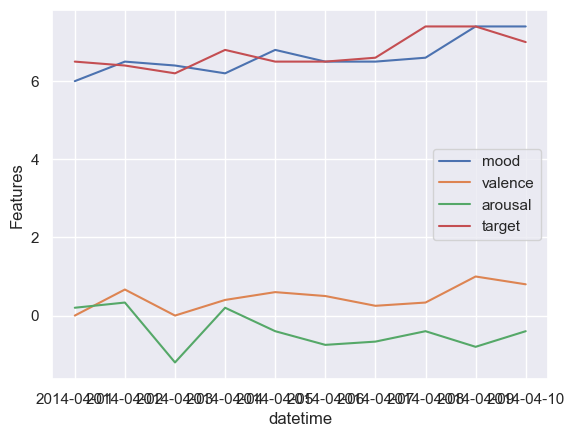

In [107]:
id = 'AS14.01'
start, end = '2014-04-01', '2014-04-10'
data = features[id]

fig, ax = plt.subplots()
sns.lineplot(data['mood'].loc[start:end], label='mood')
sns.lineplot(data['valence'].loc[start:end], label='valence')
sns.lineplot(data['arousal'].loc[start:end], label='arousal')
sns.lineplot(data['target'].loc[start:end], label='target')
ax.set_ylabel('Features')
ax.legend();

array([<Axes: xlabel='datetime'>, <Axes: xlabel='datetime'>,
       <Axes: xlabel='datetime'>, <Axes: xlabel='datetime'>,
       <Axes: xlabel='datetime'>], dtype=object)

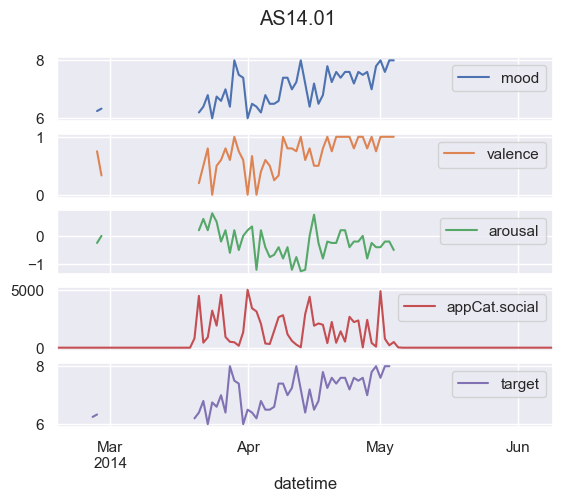

In [108]:
data.plot(subplots=True, title=id)